How to Import Files from Google Drive to Colab
參考[這裏](https://saturncloud.io/blog/how-to-import-files-from-google-drive-to-colab/)

*   Step 1: Mount Your Google Drive
*   Step 2: Locate the File You Want to Import ([img](https://saturncloud.io/images/blog/files-to-colab.png))


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

下載之前的 [clean_data_segment.pkl](https://github.com/miniricer/topic_model_example/blob/master/data_my/clean_data_segment.pkl) 檔案

並上傳到個人的google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
class_names = ["arts", "campus", "entertain", "general", "international", "life",
              "local", "money", "politics", "society", "sports", "weather"]
df = pd.read_pickle('/content/drive/MyDrive/clean_data_segment.pkl')
df.head(3)

,ids,contents,num_word,topics
0,life_0001,豪 大雨 造成 南部 地區 重大 災情 除了 淹水 災民 收拾 家園 很 辛苦 也 要 帶 ...,203,life
1,sports_0002,年 全國 運動會 月份 將在 桃園 登場 主辦 的 桃園 市政府 找來 男性 時尚 媒體 跨...,161,sports
2,international_0003,月底 美台 國防 工業會 議將 在 美國 登場國 防部 證實 確實 有 收到 邀請 函 但國...,80,international


將 topics 轉爲數字， 成爲label

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df['labels'] = labelencoder.fit_transform(df['topics'])
df.head(3)

,ids,contents,num_word,topics,labels
0,life_0001,豪 大雨 造成 南部 地區 重大 災情 除了 淹水 災民 收拾 家園 很 辛苦 也 要 帶 ...,203,life,5
1,sports_0002,年 全國 運動會 月份 將在 桃園 登場 主辦 的 桃園 市政府 找來 男性 時尚 媒體 跨...,161,sports,10
2,international_0003,月底 美台 國防 工業會 議將 在 美國 登場國 防部 證實 確實 有 收到 邀請 函 但國...,80,international,4


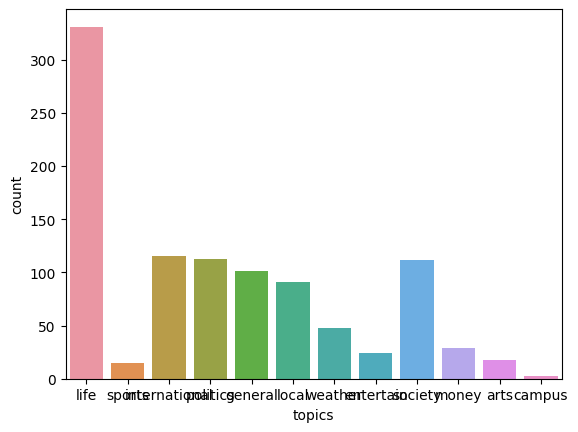

In [ ]:
import seaborn as sns
ax = sns.countplot(x="topics",data=df)

In [ ]:
# For DistilBERT:
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-chinese')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

model.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

In [ ]:
sample_txt = '豪 大雨 造成 南部 地區 重大 災情 除了 淹水 災民 收拾 家園 很 辛苦 也 要'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: 豪 大雨 造成 南部 地區 重大 災情 除了 淹水 災民 收拾 家園 很 辛苦 也 要
   Tokens: ['豪', '大', '雨', '造', '成', '南', '部', '地', '區', '重', '大', '災', '情', '除', '了', '淹', '水', '災', '民', '收', '拾', '家', '園', '很', '辛', '苦', '也', '要']
Token IDs: [6498, 1920, 7433, 6863, 2768, 1298, 6956, 1765, 1281, 7028, 1920, 4134, 2658, 7370, 749, 3922, 3717, 4134, 3696, 3119, 2896, 2157, 1754, 2523, 6789, 5736, 738, 6206]


In [ ]:
df200 = df.loc[(df['num_word'] <= 200)]

In [ ]:
df200.shape

(462, 5)

In [ ]:
tokenized = df200['contents'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

In [ ]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [ ]:
np.array(padded).shape

(462, 375)

In [ ]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(462, 375)

In [ ]:
input_ids = torch.tensor(padded)
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [ ]:
features = last_hidden_states[0][:,0,:].numpy()

In [ ]:
labels = df200['labels']

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

In [ ]:
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)

LogisticRegression()

In [ ]:
lr_clf.score(test_features, test_labels)

0.6379310344827587

In [ ]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier()

scores = cross_val_score(clf, train_features, train_labels)
print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Dummy classifier score: 0.275 (+/- 0.00)


[參考](https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/)